In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import xgboost as xgb
import pandas as pd
from rdkit.Chem import AllChem, DataStructs
from sklearn.metrics import make_scorer


#  1. Load Data and Delete duplicates

In [26]:



def delete_rows_with_same_values(df, columns_to_check):
    X = df.copy()  # Make a copy of the DataFrame to avoid modifying the original
    X.sort_values(by="ddG", ascending=False)
    # Identify rows where specified columns have the same value
    rows_to_delete = X.duplicated(subset=columns_to_check, keep='first') 

    # Invert the boolean mask to keep rows that don't have the same values in specified columns
    X_filtered = X[~rows_to_delete]

    return X_filtered

columns_to_check_for_duplicates = ['starting electrophile SMILES', 'nucleophile SMILES',
        '3,3 Catalyst Substituent ', 'Temperature (Kelvin)', 
        'N Catalyst Substituent']

In [27]:
result = pd.read_csv("../Data/merged_max.csv")
result = delete_rows_with_same_values(result, columns_to_check_for_duplicates)
result.to_csv("../Data/clean_merged_max.csv")
result= pd.read_csv("../Data/clean_merged_max.csv")#Relod to recount rows

# 2. Load Fingerprints Descrciptors

In [28]:
from functions.common_functions import *

electrophileSMILES = result['input electrophile SMILES'].values
nucleophileSMILES = result['nucleophile SMILES'].values
threethreesubSMILES = result['3,3 Catalyst Substituent '].values



def smi2FP(smiles, radius=2, nBits=2048):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    fps = [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits) for mol in mols]
    fps_arr = []
    for fp in fps:
        arr = np.zeros((nBits,), dtype=int)  # Initialize a NumPy array with the correct dtype
        DataStructs.ConvertToNumpyArray(fp, arr)
        fps_arr.append(arr)
    return pd.DataFrame(fps_arr)

electrophilefps = smi2FP(electrophileSMILES)
nucleophilefps = smi2FP(nucleophileSMILES)
threethreesubfps = smi2FP(threethreesubSMILES)

allfps = electrophilefps.join(nucleophilefps, lsuffix='electrophile', rsuffix='nucleophile').join(threethreesubfps, rsuffix='threethreesub')
allfps.columns = allfps.columns.astype(str)

# 3. Data Engineering

In [29]:
T = result.loc[:,['Temperature (Kelvin)', '3,3 Catalyst Substituent ','input electrophile SMILES', 'nucleophile SMILES', 'starting electrophile SMILES', 'N Catalyst Substituent']]

ddg= result.loc[:,'ddG']

ddg


0      1.231712
1      1.066407
2      1.002518
3      0.896691
4      1.033884
         ...   
318    1.338303
319    1.338303
320    1.092856
321    1.195347
322    0.537292
Name: ddG, Length: 323, dtype: float64

In [30]:

unique_counts = allfps.nunique()

# Get the column names where there is more than one unique value
cols_to_keep = unique_counts[unique_counts > 1].index

# Create a new DataFrame with only the selected columns
result_df = allfps[cols_to_keep]
result_df

,0electrophile,1electrophile,2electrophile,9electrophile,12electrophile,13electrophile,14electrophile,16electrophile,24electrophile,25electrophile,...,1928,1942,1958,1964,1980,1984,1999,2017,2028,2037
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
319,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
320,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
alldesc = pd.concat([result_df ,T], axis=1)

alldesc

,0electrophile,1electrophile,2electrophile,9electrophile,12electrophile,13electrophile,14electrophile,16electrophile,24electrophile,25electrophile,...,1999,2017,2028,2037,Temperature (Kelvin),"3,3 Catalyst Substituent",input electrophile SMILES,nucleophile SMILES,starting electrophile SMILES,N Catalyst Substituent
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,195.15,c2ccc1ccccc1c2,O=Cc2ccc1ccccc1c2,C=CC[Si](C)(C)C,O=Cc2ccc1ccccc1c2,NS(=O)(=O)C(F)(F)F
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,195.15,c2ccc1ccccc1c2,COc2ccc1cc(C=O)ccc1c2,C=CC[Si](C)(C)C,COc2ccc1cc(C=O)ccc1c2,NS(=O)(=O)C(F)(F)F
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,195.15,c2ccc1ccccc1c2,O=Cc2ccc1cc(Br)ccc1c2,C=CC[Si](C)(C)C,O=Cc2ccc1cc(Br)ccc1c2,NS(=O)(=O)C(F)(F)F
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,195.15,c2ccc1ccccc1c2,O=Cc1ccccc1,C=CC[Si](C)(C)C,O=Cc1ccccc1,NS(=O)(=O)C(F)(F)F
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,213.15,c1ccc3c(c1)CCc2ccccc23,O=Cc1ccccc1F,C=CC[Si](C)(C)C,O=Cc1ccccc1F,NS(=O)(=O)C(F)(F)F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,173.15,c3ccc2ccc1ccccc1c2c3,CC/C=C(C)/C=O,C1=CCC=C1,CC/C=C(C)/C=O,NS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
319,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,173.15,c3ccc2ccc1ccccc1c2c3,O=CC1=CCCCC1,C1=CCC=C1,O=CC1=CCCCC1,NS(=O)(=O)C(F)(F)C(F)(F)F
320,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,173.15,c3ccc2ccc1ccccc1c2c3,C/C=C(C)/C=O,C1=CCC=C1,C/C=C(C)/C=O,NS(=O)(=O)C(F)(F)C(F)(F)F
321,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,173.15,c3ccc2ccc1ccccc1c2c3,O=CC1=CCCC1,C1=CCC=C1,O=CC1=CCCC1,NS(=O)(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F


# 4. Divide data into reaction classes

In [32]:
filtered_df = alldesc[alldesc['nucleophile SMILES'] == alldesc['starting electrophile SMILES']]
list_one = np.unique(filtered_df['starting electrophile SMILES'])

list_two = ['C=C(OC)O[Si](C)(C)C','C=C(OC)O[Si](C)(C)C(C)(C)C','CO/C(O[Si](C)(C)C)=C(C)/C','C=C(OC)O[Si](CC)(CC)CC',
'C=C(OC)O[Si]1(C(C)C)C(C)CC1C','C=C(OC1CCCCC1)O[Si](C)(C)C(C)(C)C','C=C(OCc1ccccc1)O[Si](C)(C)C',
'C=C(OCc1ccccc1)O[Si](C)(C)C(C)(C)C','CO/C(=C\C(C)C)O[Si](C)(C)C','CO/C(=C/c1ccccc1)O[Si](C)(C)C','CO/C(=C\c1ccccc1)O[Si](C)(C)C',
'C=CO[Si](C)(C)C(C)(C)C','C=CO[Si](CC)(CC)CC','C=C(/C=C/c1ccccc1)O[Si](C)(C)C(C)(C)C','C=C(O[Si](C)(C)C(C)(C)C)c1ccccc1','C=CC[Si](C)(C)C',
'C=C1C=C(O[Si](C)(C)C)OC(C)(C)O1','C=C(OC)O[Si](C(C)C)(C(C)C)C(C)C','C=C(OC)O[Si](C(C)C)(C(C)C)C(C)C','C=C/C=C(OC(C)C)\O[Si](C)(C)C(C)(C)C',
'C=C/C=C(OC(C)C)\O[Si](C)(C)C(C)(C)C'     ,'CO/C(O[Si](C)(C)C)=C/1CCC1','CO/C(O[Si](C)(C)C)=C/1CCCC1','CO/C(O[Si](C)(C)C)=C/1CCCCC1']


unique_values = [alldesc[col].unique() for col in ['nucleophile SMILES', 'starting electrophile SMILES']]
list_three= [value for value in unique_values[0] if (value not in list_one and value not in list_two)]
filtered_df = alldesc[alldesc['nucleophile SMILES'] == alldesc['starting electrophile SMILES']]
len(filtered_df['starting electrophile SMILES'])

def categorize_id(id):
    if id in list_one:
        return 1
    elif id in list_two:
        return 2
    elif id in list_three:
        return 3
    else:
        return 'Unknown'

# Add a new column 'reaction_group' to the DataFrame based on the categorization
alldesc['reaction_group'] = alldesc['nucleophile SMILES'].apply(categorize_id)
react_groups = alldesc['nucleophile SMILES'].apply(categorize_id)
alldesc = pd.get_dummies(alldesc, columns=['reaction_group'])

alldesc = alldesc.drop(columns=['nucleophile SMILES','input electrophile SMILES','starting electrophile SMILES',
'N Catalyst Substituent','3,3 Catalyst Substituent '])

# 5. Split & Visualize Data 

In [33]:
from sklearn.preprocessing import PowerTransformer

xtrain, xtest, ytrain, ytest = train_test_split(alldesc, ddg, test_size=0.2, stratify=react_groups,random_state=1)


In [34]:
xtrain.columns

Index(['0electrophile', '1electrophile', '2electrophile', '9electrophile',
       '12electrophile', '13electrophile', '14electrophile', '16electrophile',
       '24electrophile', '25electrophile',
       ...
       '1980', '1984', '1999', '2017', '2028', '2037', 'Temperature (Kelvin)',
       'reaction_group_1', 'reaction_group_2', 'reaction_group_3'],
      dtype='object', length=944)

# 6. Test of different model frameworks

R² Score: 0.542
Mean Squared Error: 0.134
Mean Absolute Error: 0.273


(0.0, 3.0)

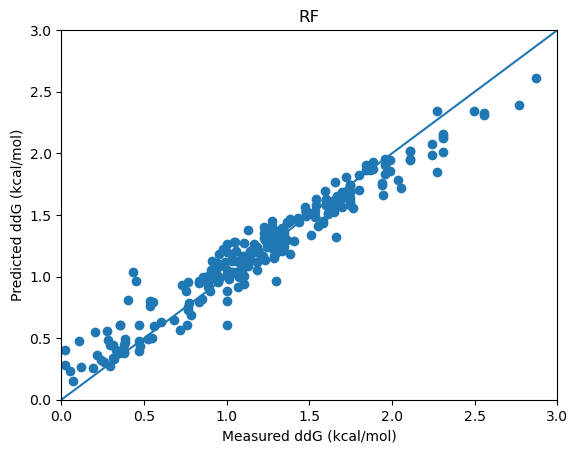

In [35]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

regressor = RandomForestRegressor().fit(xtrain, ytrain)
ypred = regressor.predict(xtrain)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation predictions
ypred_cv = cross_val_predict(regressor, xtrain, ytrain, cv=cv)

# Cross-validated R2 score, MSE, and MAE
scores_r2 = cross_val_score(regressor, xtrain, ytrain, scoring='r2', cv=cv)
scores_mse = cross_val_score(regressor, xtrain, ytrain, scoring='neg_mean_squared_error', cv=cv)
scores_mae = cross_val_score(regressor, xtrain, ytrain, scoring='neg_mean_absolute_error', cv=cv)

# Average scores for reporting
r2_average = np.mean(scores_r2)
mse_average = -np.mean(scores_mse)  # Note the negation because scores return negative values for loss
mae_average = -np.mean(scores_mae)  # Note the negation for the same reason
print(f'R² Score: {r2_average:.3f}')
print(f'Mean Squared Error: {mse_average:.3f}')
print(f'Mean Absolute Error: {mae_average:.3f}')

plt.scatter(ytrain, ypred)
plt.xlabel('Measured ddG (kcal/mol)')
plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('RF')
plt.xlim([0,3])
plt.plot([0,3],[0,3])
plt.ylim([0,3])


R² Score: 0.547
Mean Squared Error: 0.134
Mean Absolute Error: 0.272


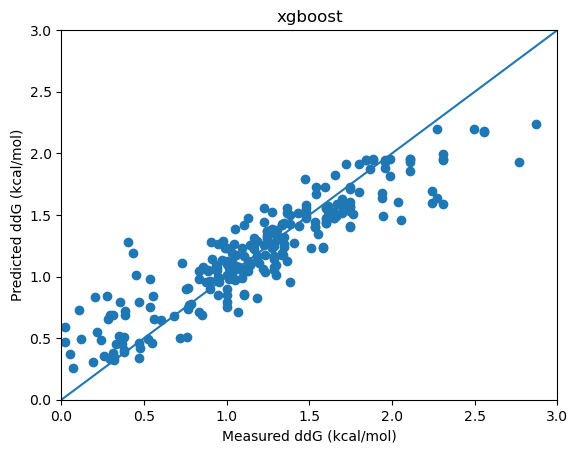

In [36]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=200, learning_rate=0.03, max_depth=5, alpha=1.5)

# Fit the model to the training data
xg_reg.fit(xtrain, ytrain)

# Predict on the test set
ypred = xg_reg.predict(xtrain)
# Evaluate the model
plt.scatter(ytrain, ypred)
plt.xlabel('Measured ddG (kcal/mol)')
plt.xlim([0,3])
plt.plot([-3,3],[-3,3])
plt.ylim([0,3])
plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('xgboost')
cv = KFold(n_splits=10, shuffle=True, random_state=40)

# Perform cross-validation predictions
ypred_cv = cross_val_predict(xg_reg, xtrain, ytrain, cv=cv)

# Cross-validated R2 score, MSE, and MAE
scores_r2 = cross_val_score(xg_reg, xtrain, ytrain, scoring='r2', cv=cv)
scores_mse = cross_val_score(xg_reg, xtrain, ytrain, scoring='neg_mean_squared_error', cv=cv)
scores_mae = cross_val_score(xg_reg, xtrain, ytrain, scoring='neg_mean_absolute_error', cv=cv)

# Average scores for reporting
r2_average = np.mean(scores_r2)
mse_average = -np.mean(scores_mse)  # Note the negation because scores return negative values for loss
mae_average = -np.mean(scores_mae)  # Note the negation for the same reason
print(f'R² Score: {r2_average:.3f}')
print(f'Mean Squared Error: {mse_average:.3f}')
print(f'Mean Absolute Error: {mae_average:.3f}')

R² Score: 0.547
Mean Squared Error: 0.130
Mean Absolute Error: 0.263


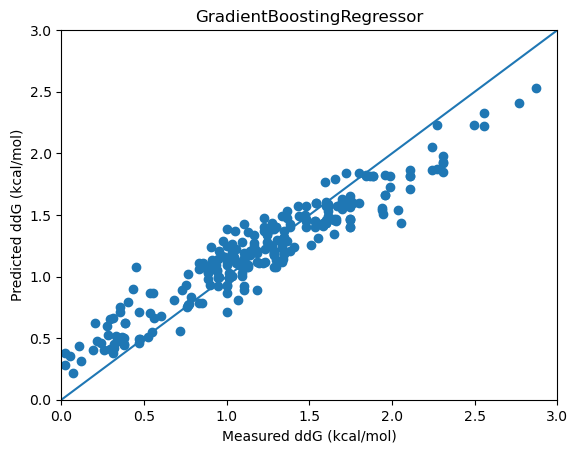

In [37]:
from sklearn.ensemble import GradientBoostingRegressor


# Create a GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.03, max_depth=5, random_state=42)

# Fit the model to the training data
gb_reg.fit(xtrain, ytrain)
ypred = gb_reg.predict(xtrain)
# Evaluate the model
plt.scatter(ytrain, ypred)
plt.xlabel('Measured ddG (kcal/mol)')
plt.xlim([0,3])
plt.plot([-3,3],[-3,3])
plt.ylim([0,3])
plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('GradientBoostingRegressor')
cv = KFold(n_splits=10, shuffle=True, random_state=4)

# Perform cross-validation predictions
ypred_cv = cross_val_predict(gb_reg, xtrain, ytrain, cv=cv)

# Cross-validated R2 score, MSE, and MAE
scores_r2 = cross_val_score(gb_reg, xtrain, ytrain, scoring='r2', cv=cv)
scores_mse = cross_val_score(gb_reg, xtrain, ytrain, scoring='neg_mean_squared_error', cv=cv)
scores_mae = cross_val_score(gb_reg, xtrain, ytrain, scoring='neg_mean_absolute_error', cv=cv)

# Average scores for reporting
r2_average = np.mean(scores_r2)
mse_average = -np.mean(scores_mse)  # Note the negation because scores return negative values for loss
mae_average = -np.mean(scores_mae)  # Note the negation for the same reason
print(f'R² Score: {r2_average:.3f}')
print(f'Mean Squared Error: {mse_average:.3f}')
print(f'Mean Absolute Error: {mae_average:.3f}')

R² Score: 0.383
Mean Squared Error: 0.171
Mean Absolute Error: 0.305


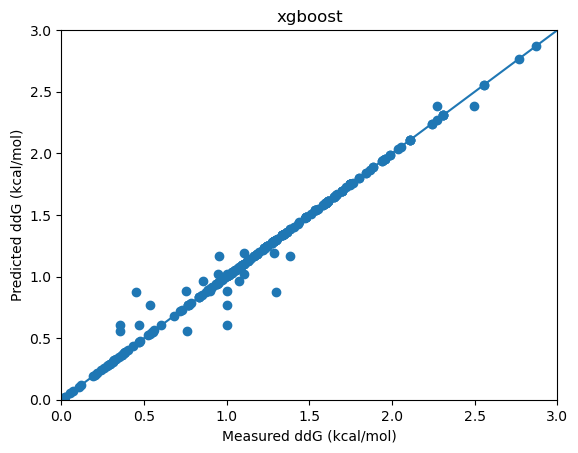

In [38]:
from sklearn.ensemble import ExtraTreesRegressor

extree_reg =  ExtraTreesRegressor(n_estimators=100)



extree_reg.fit(xtrain, ytrain)
ypred = extree_reg.predict(xtrain)
# Evaluate the model
plt.scatter(ytrain, ypred)
plt.xlabel('Measured ddG (kcal/mol)')
plt.xlim([0,3])
plt.plot([-3,3],[-3,3])
plt.ylim([0,3])
plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('xgboost')
cv = KFold(n_splits=10, shuffle=True, random_state=4)

# Perform cross-validation predictions
ypred_cv = cross_val_predict(extree_reg, xtrain, ytrain, cv=cv)

# Cross-validated R2 score, MSE, and MAE
scores_r2 = cross_val_score(extree_reg, xtrain, ytrain, scoring='r2', cv=cv)
scores_mse = cross_val_score(extree_reg, xtrain, ytrain, scoring='neg_mean_squared_error', cv=cv)
scores_mae = cross_val_score(extree_reg, xtrain, ytrain, scoring='neg_mean_absolute_error', cv=cv)

# Average scores for reporting
r2_average = np.mean(scores_r2)
mse_average = -np.mean(scores_mse)  # Note the negation because scores return negative values for loss
mae_average = -np.mean(scores_mae)  # Note the negation for the same reason
print(f'R² Score: {r2_average:.3f}')
print(f'Mean Squared Error: {mse_average:.3f}')
print(f'Mean Absolute Error: {mae_average:.3f}')

R² Score: 0.425
Mean Squared Error: 0.171
Mean Absolute Error: 0.311


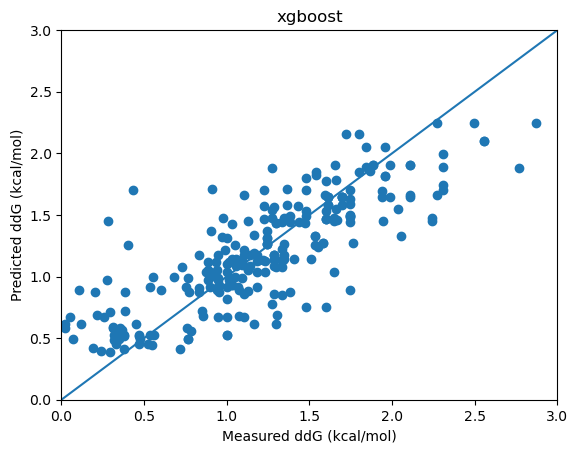

In [39]:
from sklearn.neighbors import KNeighborsRegressor

knn_regressor = KNeighborsRegressor(n_neighbors=5,weights='uniform', algorithm='auto')  # You can adjust the number of neighbors (k) based on your preference

# Fit the model
knn_regressor.fit(xtrain, ytrain)

# Make predictions on the test set
ypred = knn_regressor.predict(xtrain)
# Evaluate the model
plt.scatter(ytrain, ypred)
plt.xlabel('Measured ddG (kcal/mol)')
plt.xlim([0,3])
plt.plot([-3,3],[-3,3])
plt.ylim([0,3])
plt.ylabel('Predicted ddG (kcal/mol)')
plt.title('xgboost')
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation predictions
ypred_cv = cross_val_predict(knn_regressor, xtrain, ytrain, cv=cv)

# Cross-validated R2 score, MSE, and MAE
scores_r2 = cross_val_score(knn_regressor, xtrain, ytrain, scoring='r2', cv=cv)
scores_mse = cross_val_score(knn_regressor, xtrain, ytrain, scoring='neg_mean_squared_error', cv=cv)
scores_mae = cross_val_score(knn_regressor, xtrain, ytrain, scoring='neg_mean_absolute_error', cv=cv)

# Average scores for reporting
r2_average = np.mean(scores_r2)
mse_average = -np.mean(scores_mse)  # Note the negation because scores return negative values for loss
mae_average = -np.mean(scores_mae)  # Note the negation for the same reason
print(f'R² Score: {r2_average:.3f}')
print(f'Mean Squared Error: {mse_average:.3f}')
print(f'Mean Absolute Error: {mae_average:.3f}')

# 8. Hyperparameter Optimization and LOO CV

In [56]:
n_estimators = range(20,900)
max_depth = range(1,12)
min_samples_split = range(1,10)
min_samples_leaf = range(1,10)

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }
regressor = RandomForestRegressor(bootstrap=True)

rf_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid, cv=10, n_iter=100, scoring='r2', random_state=0)
rf_random.fit(xtrain, ytrain)

print(rf_random.best_params_)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.11/sit

{'n_estimators': 775, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 11}


In [57]:
from sklearn.model_selection import LeaveOneOut
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

best_estimator = rf_random.best_estimator_
cv_strategy = LeaveOneOut()  
mae_scores = -cross_val_score(best_estimator, xtrain, ytrain,  cv=cv_strategy,scoring=scorer)

# Calculate mean MAE
mae_mean = np.mean(mae_scores)

print("Mean Absolute Error (MAE) using LOO Cross-Validation:", mae_mean)

Mean Absolute Error (MAE) using LOO Cross-Validation: 0.2655328658865049
